## Patient Metadata Analysis

#### 1. select patient
#### 2. open ECG signal during seizure events and preictal
#### 3. calculate HR, HRV and Resp changes

In [1]:
import os
from datetime import datetime

import biosppy as bp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from neo import MicromedIO

from src.Patient import Patient

In [3]:
#main_dir = '/Volumes/T7 Touch/PreEpiSeizures/Patients_HEM/Retrospective'
main_dir = '/Volumes/My Passport/Patients_HEM/Retrospective'

patient = 'PAT_413'
patient_data = Patient(patient, main_dir)
patient_data.get_seizure_annotations()

In [4]:

list_dates = patient_data.get_file_start_date('HEM', os.path.join(patient_data.dir, 'hospital'))




In [109]:
all_df = pd.DataFrame()
for sidx in range(len(patient_data.seizure_table)):
    seizure_df = pd.DataFrame()
    seizure_date = datetime.strptime(patient_data.seizure_table.iloc[sidx]['Date'], '%d-%m-%Y\n%H:%M:%S')
    start = seizure_date - pd.Timedelta(minutes=60)
    end = seizure_date + pd.Timedelta(minutes=60)
    seizure_files = [list_dates[date] for date in list_dates.keys() if start <= date <= end]
    seizure_df = patient_data.get_file_df([file for file in seizure_files], 'trc')
    seizure_df['seizure'] = sidx
    seizure_df['time'] = seizure_df.index
    seizure_df.rename(columns={'ecg': 'ECG1'}, inplace=True)
    all_df = pd.concat([all_df, seizure_df], ignore_index=True)

In [72]:
# preictal 
seiz_info = pd.DataFrame()
keys_info = ['hr_min', 'hr_max', 'hr_minmax', 'hr_mean', 'hr_median','rr_min', 
             'rr_max', 'rr_minmax', 'rr_mean', 'rr_median', 'rmssd', 'nn50', 
             'pnn50', 'sdnn', 'hti', 'tinn', 'lf_hf', 'sd1', 'sd2', 'sd12']
for sidx in range(len(patient_data.seizure_table)):
    print('Extracting seizure info for seizure: ', sidx)
    # get preictal info
    seizure_date = datetime.strptime(patient_data.seizure_table.iloc[sidx]['Date'], '%d-%m-%Y\n%H:%M:%S')
    preictal_info = patient_data.get_seizure_info(all_df, seizure_date, keys_info, sidx, 'preictal')
    seiz_info = pd.concat([seiz_info, pd.DataFrame(preictal_info, index=[0])], ignore_index=True)
    ictal_info = patient_data.get_seizure_info(all_df, seizure_date, keys_info, sidx, 'ictal')
    posictal_info = patient_data.get_seizure_info(all_df, seizure_date, keys_info, sidx, 'posictal')
    seiz_info = pd.concat([seiz_info, pd.DataFrame(ictal_info, index=[0])], ignore_index=True)
    seiz_info = pd.concat([seiz_info, pd.DataFrame(posictal_info, index=[0])], ignore_index=True)


Extracting seizure info for seizure:  0
(384001, 3)


/Users/saraiva/dev/seizure-prediction/.venv/lib/python3.11/site-packages/biosppy/signals/hrv.py:191: UserWarning:

RR-intervals appear to be out of normal parameters. Check input values.



(33281, 3)
(384001, 3)
Extracting seizure info for seizure:  1
(59905, 3)
(33281, 3)
(384001, 3)
Extracting seizure info for seizure:  2
(99841, 3)
(33281, 3)
(384001, 3)
Extracting seizure info for seizure:  3
(53505, 3)


ValueError: A value (308.0) in x_new is above the interpolation range's maximum value (307).

In [118]:
sidx = 1
seizure_date = datetime.strptime(patient_data.seizure_table.iloc[sidx]['Date'], '%d-%m-%Y\n%H:%M:%S')
start = -pd.Timedelta(minutes=30)
end = -pd.Timedelta(minutes=5)
all_df.index = all_df['time'].iloc[:,0]
sz_df = all_df.loc[seizure_date + start: seizure_date + end]


In [131]:
hrv_info = patient_data.get_ecg_analysis(sz_df, 'ECG1', 'ECG')
hrv_info

/Users/saraiva/dev/seizure-prediction/.venv/lib/python3.11/site-packages/biosppy/signals/hrv.py:191: UserWarning:

RR-intervals appear to be out of normal parameters. Check input values.



OrderedDict([('rri',
              array([722.65625   , 714.84375   , 707.03125   , 714.84375   ,
                     722.65625   , 722.65625   , 722.65625   , 722.65625   ,
                     730.46875   , 730.46875   , 714.84375   , 718.75      ,
                     722.65625   , 726.5625    , 707.03125   , 710.9375    ,
                     707.03125   , 710.9375    , 695.3125    , 699.21875   ,
                     714.84375   , 722.65625   , 718.75      , 734.375     ,
                     738.28125   , 742.1875    , 718.75      , 726.5625    ,
                     730.46875   , 726.5625    , 714.84375   , 710.9375    ,
                     714.84375   , 722.65625   , 710.9375    , 722.65625   ,
                     730.46875   , 738.28125   , 726.5625    , 726.5625    ,
                     726.5625    , 734.375     , 718.75      , 710.9375    ,
                     714.84375   , 718.75      , 714.84375   , 703.125     ,
                     710.9375    , 714.84375   , 722.65

In [135]:
import plotly.graph_objects as go
import biosppy as bp

fig = go.Figure()
fig_df = pd.DataFrame()
fig_df['ECG'] = (sz_df['ECG1'].values - sz_df['ECG'].values).reshape(-1)
fig_df['HR'] = np.nan
fig_df.iloc[np.arange(0, len(hrv_info['hr'])*patient_data.FS, patient_data.FS)]['HR'] = hrv_info['hr']
fig_df['filter'] = bp.signals.tools.filter_signal(signal=fig_df['ECG'], ftype='FIR', band='bandpass', order=100, frequency=[3, 45], sampling_rate=patient_data.FS)['signal']
fig.add_trace(go.Scatter(x=fig_df.index, y=fig_df['filter'], mode='lines', name='ECG'))
fig.update_xaxes(title_text='Time')


IndexError: positional indexers are out-of-bounds

In [143]:

print((sz_df.index[-1]-sz_df.index[0]).total_seconds()/60)

3.9


In [1]:
# calculate resp_signal through amplitude demodulation

# 1) filter ecg signal baseline wander
ecg_signal = (preictal_df['ecg'].values - preictal_df['ECG'].values).reshape(-1)
ecg_filter = bp.signals.tools.filter_signal(signal=ecg_signal, ftype='FIR', band='highpass', order=20, frequency=0.05, sampling_rate=patient_data.FS)['signal']
ecg_peaks = bp.signals.ecg.hamilton_segmenter(signal=ecg_filter, sampling_rate=patient_data.FS)['rpeaks']
ecg_peaks = bp.signals.ecg.correct_rpeaks(signal=ecg_filter, rpeaks=ecg_peaks, sampling_rate=patient_data.FS, tol=0.05)['rpeaks']
rri = np.diff(ecg_peaks) * 1000 / patient_data.FS
resp_signal = np.zeros(len(ecg_filter))
mean_rri = int(np.mean(rri))
# carrier signal
carrier_signal = np.arange(0, len(ecg_peaks)*mean_rri, mean_rri)*0 + 1
print(len(resp_signal), mean_rri, np.std(rri))
# the modulated signal is the r peak amplitude spaced at mean rri
modulated_signal = carrier_signal * ecg_filter[ecg_peaks]
mod_fs = (1/(mean_rri))*1000
modulated_signal = bp.signals.tools.filter_signal(signal=modulated_signal, ftype='butter', band='lowpass', order=4, frequency=0.4, sampling_rate=mod_fs)['signal']

#plt.plot(np.arange(0, len(ecg_peaks)*mean_rri, mean_rri), modulated_signal)
edr = []
for idx in range(len(modulated_signal)-1):

    edr_segment = np.interp(x=np.arange(0, rri[idx], 4), xp=[0, rri[idx]], fp=[modulated_signal[idx], modulated_signal[idx+1]])
    edr.append(edr_segment)
print(len(carrier_signal))
plt.figure(figsize=(20,10))
#plt.plot(ecg_filter)
#plt.plot(edr)

plt.plot(np.hstack(edr)[:20000])


NameError: name 'preictal_df' is not defined

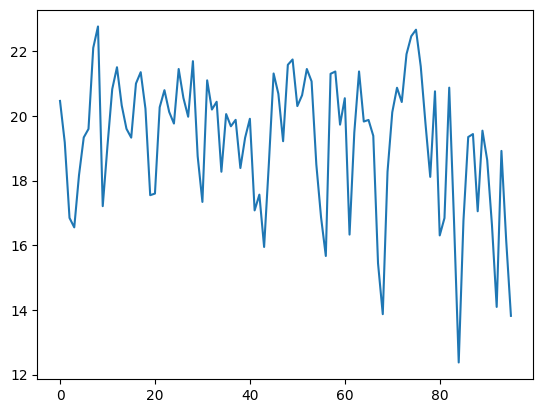

In [127]:
import numpy as np
from scipy.signal import find_peaks

# Assuming you have an EDR signal stored in a NumPy array called 'edr_signal'
window_size = 30  # Time interval for respiratory rate calculation (in seconds)
overlap = 0.5  # Overlap between consecutive windows (as a fraction)

# Set a threshold to detect peaks
threshold = 0.5  # Adjust this value based on your EDR signal characteristics

# Calculate the number of samples in the window
window_samples = int(window_size * patient_data.FS)  # Adjust 'sampling_rate' as per your EDR signal

# Calculate the number of samples to overlap
overlap_samples = int(window_samples * overlap)

# Initialize lists to store the calculated respiratory rates
respiratory_rates = []

# Perform sliding window analysis
start = 0
while start + window_samples <= len(edr_signal):
    # Extract the EDR signal within the current window
    window = edr_signal[start : start + window_samples]

    # Find peaks in the EDR signal above the threshold
    peaks, _ = find_peaks(window, height=threshold)
    
    # Calculate the time intervals between consecutive peaks
    peak_intervals = np.diff(peaks)/patient_data.FS

    # Calculate the average time interval (respiratory cycle duration)
    average_interval = np.mean(peak_intervals)

    # Calculate the respiratory rate in breaths per minute (BPM)
    respiratory_rate = 60 / average_interval

    # Append the respiratory rate to the list
    respiratory_rates.append(respiratory_rate)

    # Move the window
    start += overlap_samples

plt.plot(respiratory_rates)


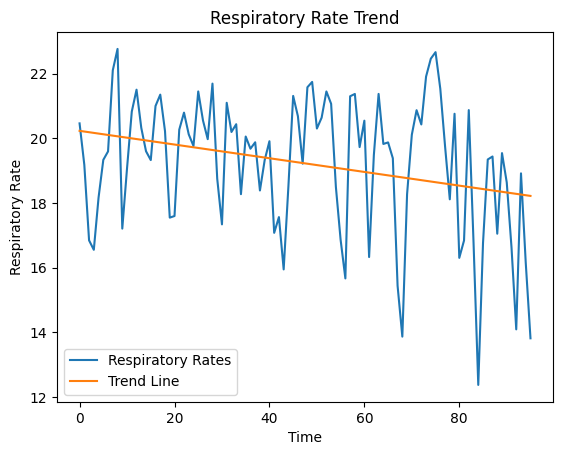

Slope: -0.02118420315039174


In [132]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have a time series of respiratory rates stored in a NumPy array called 'respiratory_rates'

# Create a time index array for plotting
time = np.arange(len(respiratory_rates))

# Perform linear regression to estimate the slope and trend
slope, intercept = np.polyfit(time, respiratory_rates, 1)

# Calculate the trend line
trend_line = slope * time + intercept

# Plot the respiratory rate time series and trend line
plt.plot(time, respiratory_rates, label='Respiratory Rates')
plt.plot(time, trend_line, label='Trend Line')
plt.xlabel('Time')
plt.ylabel('Respiratory Rate')
plt.title('Respiratory Rate Trend')
plt.legend()
plt.show()

# Print the calculated slope
print("Slope:", slope)


In [135]:
sz_dict = {'maxRR':np.max(respiratory_rates), 'minRR':np.min(respiratory_rates), 'meanRR':np.mean(respiratory_rates), 'stdRR':np.std(respiratory_rates), 'slopeRR':slope}
sz_dict2 = {'power':np.sum(np.square(respiratory_rates)), 'meanRR':np.mean(respiratory_rates), 'stdRR':np.std(respiratory_rates), 'slopeRR':slope}
sz_dict.update(sz_dict2)
sz_dict

{'maxRR': 22.76782104837623,
 'minRR': 12.375120850789559,
 'meanRR': 19.227731471243107,
 'stdRR': 2.1106653082987763,
 'slopeRR': -0.02118420315039174,
 'power': 35919.41429509332}

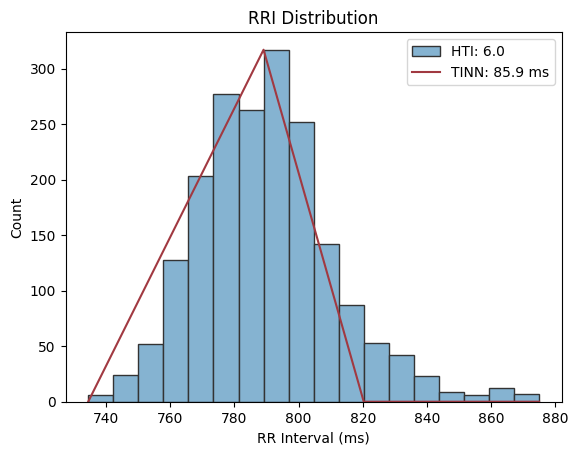

In [9]:
tmin = preictal_info['rri'].min()
tmax = preictal_info['rri'].max()
binsize= (1/128) * 1000
bins = np.arange(tmin, tmax + binsize, binsize)
bp.plotting.plot_hrv_hist(rri=preictal_info['rri'], bins=bins, q_hist=preictal_info['q_hist'], hti=preictal_info['hti'], tinn = preictal_info['tinn'])

In [8]:
import plotly.graph_objects as go
fig = go.Figure()

fig.add_trace(go.Scatter(x=preictal_df.index[preictal_info['peaks']], y=preictal_info['hr'], mode='lines', name='preictal'))
fig.show()

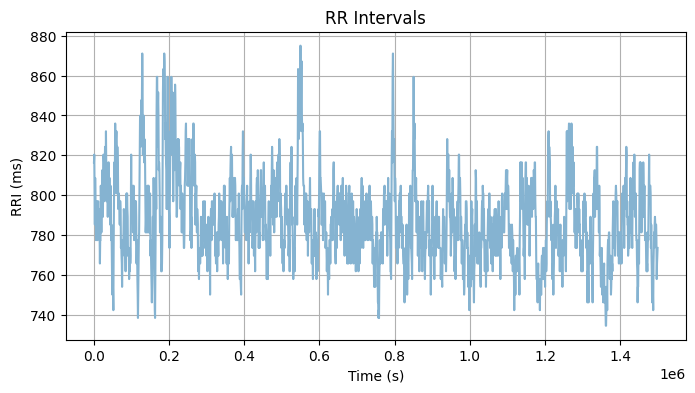

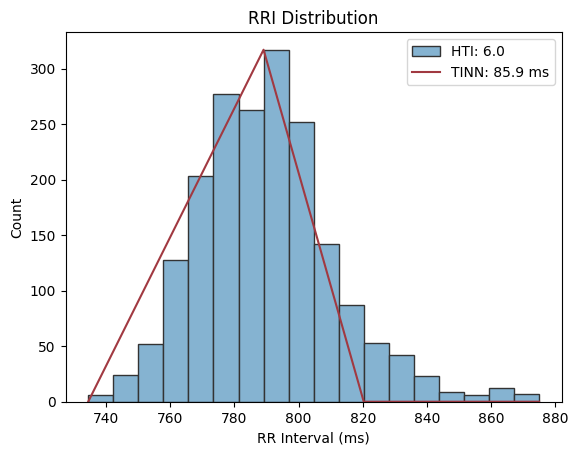

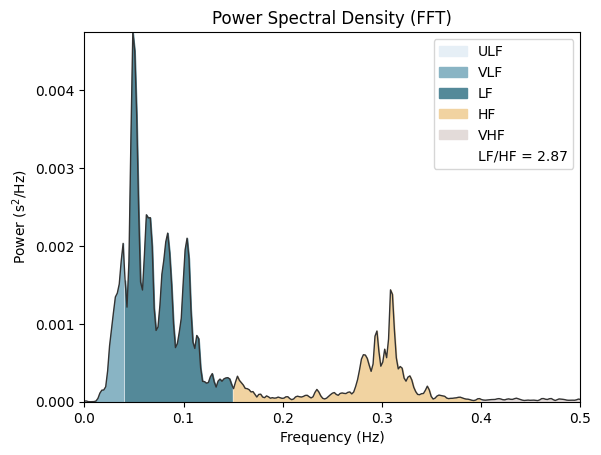

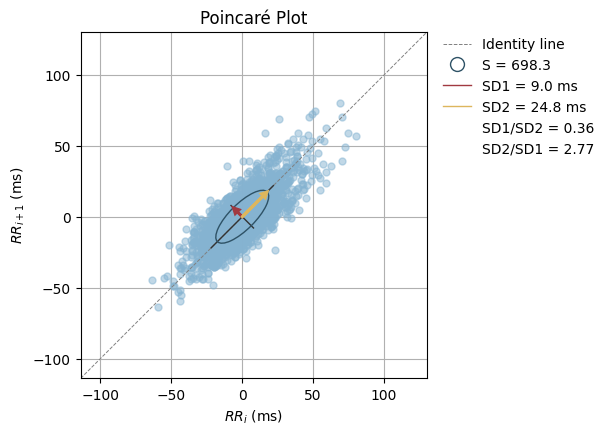

In [10]:
ecg_signal = (preictal_df['ecg'].values - preictal_df['ECG'].values).reshape(-1)
ecg_peaks = bp.signals.ecg.hamilton_segmenter(signal=ecg_signal, sampling_rate=patient_data.FS)[0]
ecg_peaks = bp.signals.ecg.correct_rpeaks(signal=ecg_signal, rpeaks=ecg_peaks, sampling_rate=patient_data.FS, tol=0.05)[0]
hrv_info = bp.signals.hrv.hrv(ecg_peaks, sampling_rate=patient_data.FS, show=True).as_dict()

In [ ]:
hr_time, hr_values = bp.signals.tools.get_heart_rate(ecg_peaks, sampling_rate=FS)
smooth_hr = bp.signals.tools.smoother(signal=hr_values, kernel='boxzen', size=5)['signal']
filter_hr = bp.signals.tools.filter_signal(signal=hr_values, ftype='butter', band='lowpass', order=2, frequency=10, sampling_rate=FS)['signal']
seizure_df['hr'] = np.nan
seizure_df['hr'].iloc[hr_time] = filter_hr
seizure_df.dropna()


/var/folders/jv/_bqrt3cs093f3fmttdr0hpnm0000gn/T/ipykernel_5143/695987372.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,ecg,ECG,index,hr,nni
213,240.820312,2.441406,2020-09-22 20:29:07.832032152,83.487342,718.704
398,236.621094,-2.441406,2020-09-22 20:29:08.554689186,83.361484,722.610
585,250.000000,-29.296875,2020-09-22 20:29:09.285158729,83.235729,730.422
774,258.007812,-2.539062,2020-09-22 20:29:10.023440780,83.118995,738.234
958,315.234375,42.480469,2020-09-22 20:29:10.742191560,83.016782,718.704
...,...,...,...,...,...
1842410,-338.476562,-462.890625,2020-09-22 22:29:04.886715337,104.394162,472.626
1842643,-95.019531,-43.066406,2020-09-22 22:29:05.796872575,104.081953,910.098
1842754,199.609375,-139.160156,2020-09-22 22:29:06.230466796,103.501175,433.566
1842905,-124.902344,25.976562,2020-09-22 22:29:06.820311186,102.696476,589.806


In [ ]:
nni_values = (np.diff(ecg_peaks)/FS)*1000

filter_nni = bp.signals.tools.filter_signal(signal=nni_values, ftype='butter', band='lowpass', order=2, frequency=10, sampling_rate=FS)['signal']
hrv_values = np.diff(filter_nni)
seizure_df['nni'] = np.nan
seizure_df['nni'].iloc[ecg_peaks[1:-1]] = hrv_values


/var/folders/jv/_bqrt3cs093f3fmttdr0hpnm0000gn/T/ipykernel_5143/4290936192.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [107]:
import plotly.graph_objects as go

fig = go.Figure()

#fig.add_trace(go.Scatter(x=seizure_df['index'], y=ecg_signal, mode='lines', name='ECG'))
fig.add_vline(x=seizure_date)
#fig.add_trace(go.Scatter(x=seizure_df['index'].iloc[ecg_peaks], y=ecg_signal[ecg_peaks], mode='markers', name='ECG Peaks'))
fig.add_trace(go.Scatter(x=seizure_df.dropna()['index'], y=seizure_df.dropna()['hr'], mode='lines', name='HR'))
fig.add_trace(go.Scatter(x=seizure_df.dropna()['index'], y=seizure_df.dropna()['nni'], mode='lines', name='NNI'))

fig.show()